<a href="https://colab.research.google.com/github/Samukelo09/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df = pd.read_csv(r"/content/drive/MyDrive/dataset/sentiment_dataset.csv")
file_path = "/content/drive/MyDrive/dataset/sentiment_dataset.csv"

# column names (since the file has no headers)
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

df = pd.read_csv(file_path, encoding='latin-1', names=columns)

# drop the unnececary columns
df = df[['text', 'target']]

print(f"Shape: {df.shape}")
df.head()

In [ ]:
# define the english stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
# function for cleaning up text (e.g. removing the @ tags from the tweets)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_text)

# convert targets: 0 -> 0 (negative), 4 -> 1 (positive)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

df[['cleaned_text', 'target']].head()

# GRU Model

In [9]:
file_path = "/content/drive/MyDrive/sentiment_dataset/sentiment_analysis_dataset.csv"

In [5]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

Load and, Clean Preprocess the Data

In [10]:
#Load and clean data
data = pd.read_csv(file_path, encoding='latin-1', header=None)
data = data[[0, 5]]
data.columns = ['label', 'text']
data['label'] = data['label'].map({0: 0, 4: 1})

def clean_text(text):
    text = re.sub(r'@[\w]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower().strip()
    return text

data['text'] = data['text'].apply(clean_text)


Tokenize and Pad Sequences

Train/Test Split

In [11]:
# Tokenize and pad
max_words = 20000
max_len = 40
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])

X = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
y = data['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Define GRU Model

In [14]:
# Model Definition
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    GRU(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,305,025 (4.98 MB)

 Trainable params: 1,305,025 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [15]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)


Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 497s 49ms/step - accuracy: 0.6950 - loss: 0.5263 - val_accuracy: 0.8214 - val_loss: 0.3944
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 501s 50ms/step - accuracy: 0.8297 - loss: 0.3797 - val_accuracy: 0.8260 - val_loss: 0.3853
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 503s 50ms/step - accuracy: 0.8413 - loss: 0.3578 - val_accuracy: 0.8275 - val_loss: 0.3831
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 554s 49ms/step - accuracy: 0.8526 - loss: 0.3367 - val_accuracy: 0.8257 - val_loss: 0.3896
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 513s 51ms/step - accuracy: 0.8631 - loss: 0.3154 - val_accuracy: 0.8241 - val_loss: 0.4107


Plot Accuracy and Loss

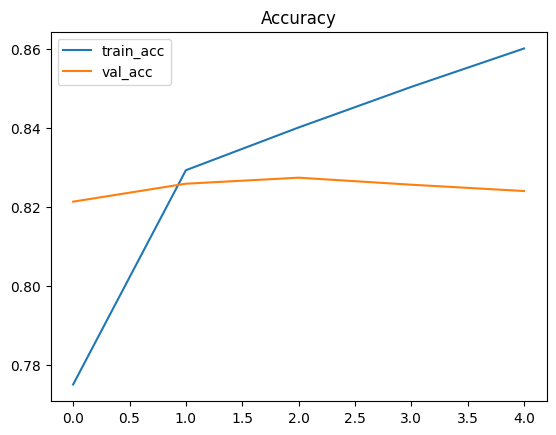

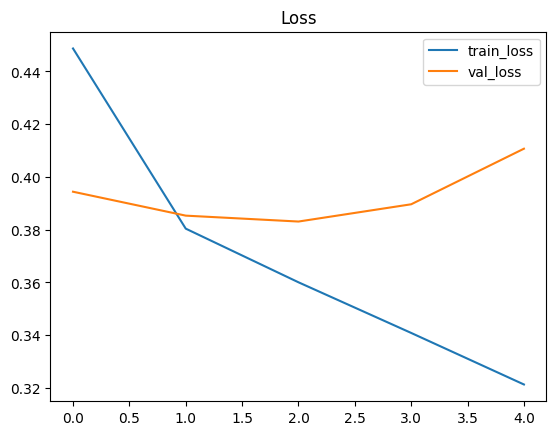

In [18]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


Save Model and Tokenizer

In [23]:
# Save model and tokenizer
from google.colab import files
import pickle

# Save model in recommended format
model.save('gru_sentiment_model.keras')

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Download files
files.download('gru_sentiment_model.keras')
files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
uploaded = files.upload()

Saving gru_sentiment_model.keras to gru_sentiment_model (1).keras


In [25]:
uploaded = files.upload()

Saving tokenizer.pkl to tokenizer (2).pkl


In [26]:
# Load model
model = tf.keras.models.load_model('gru_sentiment_model.keras')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [49]:
def tweet_prediction(tweet):
    cleaned_tweet = [clean_text(t) for t in tweet]
    seqs = tokenizer.texts_to_sequences(cleaned_tweet)
    padded = pad_sequences(seqs, maxlen=40, padding='post', truncating='post')

    # Predict
    preds = model.predict(padded)
    labels = (preds > 0.5).astype(int)

    for text, label in zip(tweet, labels):
        print(f"{text} → {'Positive' if label[0] == 1 else 'Negative'}")


In [50]:
# Sample text
sample_texts = ["I love this product!", "This is terrible and awful."]
tweet_prediction(sample_texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
I love this product! → Positive
This is terrible and awful. → Negative


In [45]:
my_tweets = [
    "Creistiano Ronaldo is there greatest player to ever grace football.",
    "I've lost hope in Real Madrid.",
    "My friend is a bachelor, it's not even funny anymore.",
    "I don't know why Vini didn't win the Ballon d'Or"
]
tweet_prediction(my_tweets)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Creistiano Ronaldo is there greatest player to ever grace football. → Positive
I've lost hope in Real Madrid. → Negative
My friend is a bachelor, it's not even funny anymore. → Negative
I don't know why Vini didn't win the Ballon d'Or → Negative


In [52]:
sample_tweets = [
    "I absolutely love the new update! So smooth and fast. 👏",
    "Worst experience ever. App keeps crashing. 😡",
    "It’s okay, not too bad but not great either.",
    "She promised not to do anything against my will.",
    "Amazing customer service. Thank you so much!",
    "I’m never using this again. Waste of time.",
    "The weather is kinda gloomy today.",
    "Feeling grateful for everything. Life is good. 🙏",
    "Why is this still not working? So frustrating.",
    "Just finished watching the series. Pretty decent ending!"
]
tweet_prediction(sample_tweets)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
I absolutely love the new update! So smooth and fast. 👏 → Positive
Worst experience ever. App keeps crashing. 😡 → Negative
It’s okay, not too bad but not great either. → Negative
She promised not to do anything against my will. → Negative
Amazing customer service. Thank you so much! → Positive
I’m never using this again. Waste of time. → Negative
The weather is kinda gloomy today. → Negative
Feeling grateful for everything. Life is good. 🙏 → Positive
Why is this still not working? So frustrating. → Negative
Just finished watching the series. Pretty decent ending! → Positive
